In [1]:
from dataset import SFMNNDataset
from network import SFMNNEncoder
from simulate import SFMNNSimulation
from loss import SFMNNLoss
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from dotenv import load_dotenv
import logging
import numpy as np

/home/omirako/.local/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
load_dotenv()
data_folder = os.getenv("DATA_FOLDER")

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

with open(data_folder + "simulation_sim_0_amb_0.json") as f:
    data = json.load(f)
with open(data_folder + "simulation_lookuptable.json") as f:
    lookup = json.load(f)

# Load the dataset
dataset = SFMNNDataset(data_folder + 'simulation_lookuptable.json', 'output/', patch_size=5)

# Load the dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)


2025-03-21 18:44:20,227 [INFO] Using 3620 wavelength channels.
2025-03-21 18:44:20,229 [INFO] Found 1350 simulation JSON files.
Loading JSON files:   0%|          | 0/1350 [00:00<?, ?it/s]

Loading JSON files: 100%|██████████| 1350/1350 [00:15<00:00, 84.76it/s]
2025-03-21 18:44:36,515 [INFO] Fixed Esun computed as: 268.4315
2025-03-21 18:44:36,597 [INFO] Total simulations loaded: 1350
2025-03-21 18:44:36,598 [INFO] Total patches loaded: 60


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Number of spectral bands
n_spectral_bands = len(dataset.get_wl())
n_spectral_bands

3620

In [5]:
C,H,W = dataset[0].shape
H, W, C

(5, 5, 3623)

In [6]:
# Initialize the network
encoder = SFMNNEncoder(input_channels=C,num_variables = 9 ,latent_dim=C).to(device)

print(encoder)

SFMNNEncoder(
  (input_norm): BatchNorm1d(3623, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=3623, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=4096, out_features=8192, bias=True)
    (5): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=8192, out_features=16384, bias=True)
    (9): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=16384, out_features=16384, bias=True)
    (12): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (latent_proj): Linear(in_features=16384, out_features=32607, bias=True)
)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F_func

class FourStreamSimulator(nn.Module):
    def __init__(self, spectral_window=(750, 770), high_res=0.0055):
        super().__init__()
        self.register_buffer('lambda_hr', torch.arange(*spectral_window, high_res))
        self.mu_f = 737.0  # Fluorescence peak wavelength

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s):
        # Expand cos_theta_s dimensions [B, H, W] -> [B, 1, H, W]
        cos_theta_s = cos_theta_s.unsqueeze(1)
        
        # Compute product terms
        denominator = 1 - t3 * R + 1e-6
        t7 = t3 * t4
        t8 = t3 * t6
        t9 = t4 * t5
        t10 = t4 * t2
        t11 = t3 * t2
        
        numerator = t1 * t8 * R + t9 * R + t10 * R + t11 * R + t6 * F + t7 * F
        LTOA = t1 * t2 + numerator / denominator
        
        mod_factor = (E_s * cos_theta_s) / np.pi  # Now shapes: [B, 3620, H, W] * [B, 1, H, W]
        return LTOA * mod_factor

import torch
import torch.nn as nn
import torch.nn.functional as F_func

class HyPlantSensorSimulator(nn.Module):
    def __init__(self, sensor_wavelengths, high_res=0.0055):
        super().__init__()
        self.register_buffer('sensor_wavelengths', sensor_wavelengths)
        self.high_res = high_res
        self.register_buffer('wl_range', torch.tensor([
            sensor_wavelengths.min(),
            sensor_wavelengths.max()
        ]))

    def forward(self, L_hr, delta_lambda, delta_sigma):
        # L_hr: [B, C_hr, H, W]
        B, C_hr, H, W = L_hr.shape
        
        #######################
        # 1) Gaussian Blur
        #######################
        sigma = (0.27 + delta_sigma) * 2.3548  # FWHM -> std
        kernel_size = max(3, int(6 * sigma / self.high_res))
        x = torch.linspace(-3*sigma, 3*sigma, kernel_size, device=L_hr.device)
        kernel = torch.exp(-0.5 * (x / sigma) ** 2)
        kernel /= kernel.sum()

        # shape: [B*H*W, 1, C_hr]
        L_hr_reshaped = L_hr.permute(0, 2, 3, 1).reshape(B*H*W, 1, C_hr)
        L_blur = F_func.conv1d(L_hr_reshaped, kernel.view(1, 1, -1),
                               padding=kernel_size // 2)
        new_C_hr = L_blur.shape[-1]
        # reshape to [B, H, W, new_C_hr] -> [B, new_C_hr, H, W]
        L_blur = L_blur.view(B, H, W, new_C_hr).permute(0, 3, 1, 2)

        # --- Debug: see if L_blur is constant across channel dimension
        if B == 1:
            print("L_blur (per batch) min/max:",
                  L_blur.min().item(), L_blur.max().item())
            # Also check std along channel dimension:
            std_channels = L_blur.std(dim=1)  # shape [B, H, W]
            print("Mean channel-std:", std_channels.mean().item())

        #######################
        # 2) Wavelength Shifts
        #######################
        # Delta-lambda average for each batch item
        avg_delta = delta_lambda.mean(dim=(1,2)).view(B, 1)  # shape [B, 1]
        
        wl_min, wl_max = self.wl_range[0].item(), self.wl_range[1].item()
        
        shifted_wl = self.sensor_wavelengths.unsqueeze(0) + avg_delta
        shifted_wl = torch.clamp(shifted_wl, min=wl_min, max=wl_max)  # Now valid!
        
        normalized_wl = 2 * (shifted_wl - wl_min) / (wl_max - wl_min) - 1
        
        # --- Debug: check that normalized_wl is not all the same or out of bounds
        if B == 1:
            print("normalized_wl min/max:",
                  normalized_wl.min().item(), normalized_wl.max().item())

        #######################
        # 3) grid_sample setup
        #######################
        # L_blur shape is [B, new_C_hr, H, W], interpret new_C_hr as "height"
        # reshape to [B*H*W, 1, new_C_hr, 1]
        L_blur_2d = L_blur.permute(0, 2, 3, 1).reshape(
            B*H*W, 1, new_C_hr, 1
        )

        # Make grid: shape [N, out_H, out_W, 2]
        num_sensor = self.sensor_wavelengths.shape[0]  # e.g. 172

        # Expand normalized_wl from [B, num_sensor] to [B, H*W, num_sensor]
        normalized_wl_expanded = normalized_wl.unsqueeze(1).expand(
            B, H*W, num_sensor
        )
        # Reshape to [B*H*W, 1, num_sensor]
        normalized_wl_expanded = normalized_wl_expanded.reshape(
            B*H*W, 1, num_sensor
        )

        grid_y = normalized_wl_expanded  # treat as "height" coords in [-1,1]
        grid_x = torch.zeros_like(grid_y) # x=0
        grid = torch.stack((grid_y, grid_x), dim=-1)  # [B*H*W, 1, num_sensor, 2]

        # --- Debug
        if B == 1:
            print("grid y-range: [", grid_y.min().item(), ",",
                  grid_y.max().item(), "]")

        #######################
        # 4) grid_sample
        #######################
        L_sampled = F_func.grid_sample(
            L_blur_2d, grid, mode='bilinear', align_corners=True
        )
        # L_sampled shape: [B*H*W, 1, 1, num_sensor]
        L_sampled = L_sampled.view(B, H, W, num_sensor).permute(0, 3, 1, 2)

        # Debug final shape
        if B == 1:
            print("L_sampled shape:", L_sampled.shape,
                  "  min/max:", L_sampled.min().item(), L_sampled.max().item())

        return L_sampled


class SFMNNSimulation(nn.Module):
    def __init__(self, sensor_wavelengths):
        super().__init__()
        self.four_stream = FourStreamSimulator()
        self.sensor_sim = HyPlantSensorSimulator(sensor_wavelengths)

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, delta_lambda, delta_sigma, E_s, cos_theta_s):
        L_hr = self.four_stream(t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s)
        L_hyp = self.sensor_sim(L_hr, delta_lambda, delta_sigma)
        return L_hyp

In [14]:
class SFMNNLoss(nn.Module):
    def __init__(self, gamma_f=5, gamma_N=10, gamma_a=1, ndvi_threshold=0.15, red_idx=680, nir_idx=800):
        super().__init__()
        self.gamma_f = gamma_f
        self.gamma_N = gamma_N
        self.gamma_a = gamma_a
        self.ndvi_threshold = ndvi_threshold
        self.red_idx = red_idx
        self.nir_idx = nir_idx

    def forward(self, pred, target, outputs, E_s, cos_theta_s, loss_indices):
        # pred and target are already windowed (shape: [B, window_size, H, W])
        recon_loss = torch.mean((pred - target) ** 2)
        
        # NDVI loss computed from full reflectance (not windowed)
        red = outputs['reflectance'][:, self.red_idx]
        nir = outputs['reflectance'][:, self.nir_idx]
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_loss = torch.mean(outputs['sif'] * ((ndvi <= self.ndvi_threshold).float()))
        
        w_f = self.compute_w_f(target, outputs['sif'])
        signal_loss = torch.mean((pred - target) ** 2 * w_f.view(1, -1, 1, 1))
        
        # Extract window from reflectance and E_s
        R_window = outputs['reflectance'][:, loss_indices, :, :]
        R_mean = R_window.mean(dim=(2,3), keepdim=True)
        L_atm_R = pred - outputs['sif'].unsqueeze(1)
        B = E_s.size(0)
        E_s_const = E_s.mean(dim=(2,3), keepdim=True)  # [B, n_spectral_bands, 1, 1]
        E_s_window = E_s_const[:, loss_indices, :, :]
        cos_theta_s_const = cos_theta_s.mean(dim=(1,2), keepdim=True).view(B, 1, 1, 1)
        denom = E_s_window * cos_theta_s_const + 1e-6
        t_tot = (L_atm_R * R_mean) / denom
        atm_loss = torch.mean(torch.relu(t_tot - 1))
        
        total_loss = recon_loss  # regularizers not added for now
        
        loss_dict = {
            'total': total_loss,
            'recon': recon_loss,
            'signal': signal_loss,
            'ndvi': ndvi_loss,
            'atm': atm_loss
        }
        return total_loss, loss_dict

    def compute_w_f(self, L_HyP, sif_pred, epsilon=1e-6):
        f_sq = sif_pred.unsqueeze(1) ** 2
        sum_f_sq = torch.mean(f_sq, dim=(0, 2, 3))
        sigma_L2 = torch.var(L_HyP, dim=(0,2,3)) + 1e-3  # Larger epsilon
        numerator = sum_f_sq
        denominator = sum_f_sq / (sigma_L2 + epsilon)
        w_f = (1.0 / sigma_L2) * (sum_f_sq / (denominator.sum() + 1e-6))
        w_f = w_f / (w_f.sum() + 1e-6)  # Normalize weights
        return w_f

In [15]:
import numpy as np

def train_model(encoder):
    from dotenv import load_dotenv
    load_dotenv()
    data_folder = os.getenv("DATA_FOLDER")
    lookup_table_path = os.path.join(data_folder, 'simulation_lookuptable.json')
    #dataset = SFMNNDataset(lookup_table_path, data_folder, patch_size=5)
    #dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    n_spectral_bands = len(dataset.get_wl())
    # Input channels: n_spectral_bands + 3
    C = n_spectral_bands + 3
    logger.info(f"Spectral channels: {n_spectral_bands}, total input channels: {C}")

    optimizer = optim.Adam(encoder.parameters(), lr=1e-5, weight_decay=1e-5)

    # Pass the loss indices later.
    loss_fn = SFMNNLoss(red_idx=680, nir_idx=800).to(device)

    sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)
    simulation = SFMNNSimulation(sensor_wl).to(device)

    fixed_esun = dataset.fixed_esun
    logger.info(f"Using fixed Esun: {fixed_esun:.4f}")

    num_epochs = 100
    # Define spectral window indices for loss: e.g., wavelengths between 760 and 780 nm.
    indices = ((sensor_wl >= 760.0) & (sensor_wl <= 780.0)).nonzero(as_tuple=True)[0]
    logger.info(f"Loss calculated over indices: {indices.tolist()}, corresponding to {sensor_wl[indices[0]].item():.1f}-{sensor_wl[indices[-1]].item():.1f} nm.")

    for epoch in range(num_epochs):
        encoder.train()
        epoch_loss = 0.0
        num_samples = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch in pbar:
            # batch: [B, 3623, H, W]
            batch = batch.to(device)
            B, _, H, W = batch.shape
            
            n_spectral_bands = len(dataset.get_wl())  # should be 3620

            # Extract target reflectance: first n_spectral_bands channels.
            target_full = batch[:, :n_spectral_bands, :, :]
            target = target_full[:, indices, :, :]

            # Extra channels: channel order: 0..n_spectral_bands-1: LTOA, n_spectral_bands: XTE, n_spectral_bands+1: SZA, n_spectral_bands+2: GNDALT.
            sza = batch[:, n_spectral_bands+1, :, :]
            E_s = fixed_esun * torch.ones(B, n_spectral_bands, H, W, device=device)
            cos_theta_s = torch.cos(sza * np.pi / 180.0)

            latent = encoder(batch)  # Expected shape: [B, H, W, 9, latent_dim]
            # Force latent to only have the first n_spectral_bands channels
            latent = latent[:, :, :, :, :n_spectral_bands]

            t1 = latent[:, :, :, 0, :].permute(0, 3, 1, 2)  # Now shape [B, 3620, H, W]
            t2 = latent[:, :, :, 1, :].permute(0, 3, 1, 2)
            t3 = latent[:, :, :, 2, :].permute(0, 3, 1, 2)
            t4 = latent[:, :, :, 3, :].permute(0, 3, 1, 2)
            t5 = latent[:, :, :, 4, :].permute(0, 3, 1, 2)
            t6 = latent[:, :, :, 5, :].permute(0, 3, 1, 2)
            R_param = latent[:, :, :, 6, :].permute(0, 3, 1, 2)
            F_param = latent[:, :, :, 7, :].permute(0, 3, 1, 2)
            delta_lambda_enc = latent[:, :, :, 8, :].permute(0, 3, 1, 2)
            delta_lambda = delta_lambda_enc.mean(dim=1)  # [B, H, W]

            # Use a realistic delta_sigma (set to 0.0 here to preserve spectral resolution).
            sim_output_full = simulation(t1, t2, t3, t4, t5, t6, R_param, F_param,
                                          delta_lambda, torch.tensor(0.0, device=device),
                                          E_s, cos_theta_s)
            # sim_output_full: [B, 3620, H, W]
            pred = sim_output_full[:, indices, :, :]

            # Predicted SIF from F_param.
            predicted_sif = F_param.mean(dim=1)  # [B, H, W]
            outputs_dict = {
                'reflectance': sim_output_full,
                'sif': predicted_sif
            }

            total_loss, loss_dict = loss_fn(pred, target, outputs_dict, E_s, cos_theta_s, indices)
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += total_loss.item() * B
            num_samples += B

            pbar.set_postfix({
                "loss": total_loss.item(),
                "recon": loss_dict['recon'].item(),
                "signal": loss_dict['signal'].item(),
                "ndvi": loss_dict['ndvi'].item(),
                "atm": loss_dict['atm'].item()
            })
        avg_epoch_loss = epoch_loss / num_samples
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}")
        
    return encoder

if __name__ == "__main__":
    encoder = train_model(encoder)

2025-03-21 18:48:03,885 [INFO] Using device: cuda
2025-03-21 18:48:03,886 [INFO] Spectral channels: 3620, total input channels: 3623
2025-03-21 18:48:03,907 [INFO] Using fixed Esun: 268.4315
2025-03-21 18:48:03,908 [INFO] Loss calculated over indices: [2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 235

Epoch 1/100 - Avg Loss: 1961133.9048


Epoch 2/100 - Avg Loss: 801410.8467


Epoch 3/100 - Avg Loss: 427126.3132


Epoch 4/100 - Avg Loss: 671707.7924


Epoch 5/100 - Avg Loss: 1400735.0809


Epoch 6/100 - Avg Loss: 580473.3830


Epoch 7/100 - Avg Loss: 467262.5142


Epoch 8/100 - Avg Loss: 7855841.2753


Epoch 9/100 - Avg Loss: 111378.0879


Epoch 10/100 - Avg Loss: 40811.8717


Epoch 11/100 - Avg Loss: 4086242.7235


Epoch 12/100 - Avg Loss: 98536.5270


Epoch 13/100 - Avg Loss: 284733.0473


Epoch 14/100 - Avg Loss: 17131.3908


Epoch 15/100 - Avg Loss: 21023.1713


Epoch 16/100 - Avg Loss: 3870064.6135


Epoch 17/100 - Avg Loss: 710229.4114


Epoch 18/100 - Avg Loss: 412587.4130


Epoch 19/100 - Avg Loss: 30432.1463


Epoch 20/100 - Avg Loss: 33025.4364


Epoch 21/100 - Avg Loss: 288116.9215


Epoch 22/100 - Avg Loss: 63943.8563


Epoch 23/100 - Avg Loss: 1739426715.5629


Epoch 24/100 - Avg Loss: 10874.7470


Epoch 25/100 - Avg Loss: 15814.6443


Epoch 26/100 - Avg Loss: 72370577.0557


Epoch 27/100 - Avg Loss: 26142.9812


Epoch 28/100 - Avg Loss: 27361.7317


Epoch 29/100 - Avg Loss: 27452.3844


Epoch 30/100 - Avg Loss: 1635406.3369


Epoch 31/100 - Avg Loss: 31108.2351


Epoch 32/100 - Avg Loss: 753005.2855


Epoch 33/100 - Avg Loss: 95732.3786


Epoch 34/100 - Avg Loss: 65165.8861


Epoch 35/100 - Avg Loss: 74771.2542


Epoch 36/100 - Avg Loss: 56929.6506


Epoch 37/100 - Avg Loss: 8026.3198


Epoch 38/100 - Avg Loss: 1296877.2008


Epoch 39/100 - Avg Loss: 244475.5704


Epoch 40/100 - Avg Loss: 24136.2483


Epoch 41/100 - Avg Loss: 49866.5134


Epoch 42/100 - Avg Loss: 173274.2844


Epoch 43/100 - Avg Loss: 38294.4628


Epoch 44/100 - Avg Loss: 237199.0656


Epoch 45/100 - Avg Loss: 38069.9569


Epoch 46/100 - Avg Loss: 15360.8911


Epoch 47/100 - Avg Loss: 8029.2706


Epoch 48/100 - Avg Loss: 54646.1094


Epoch 49/100 - Avg Loss: 97298.8505


Epoch 50/100 - Avg Loss: 185859.6265


Epoch 51/100 - Avg Loss: 454340.5184


Epoch 52/100 - Avg Loss: 32861.3053


Epoch 53/100 - Avg Loss: 107560.4955


Epoch 54/100 - Avg Loss: 12808.4183


Epoch 55/100 - Avg Loss: 101698.5241


Epoch 56/100 - Avg Loss: 103242.5739


Epoch 57/100 - Avg Loss: 3522.4006


Epoch 58/100 - Avg Loss: 32072.4879


Epoch 59/100 - Avg Loss: 2942985.0718


Epoch 60/100 - Avg Loss: 15678.9048


Epoch 61/100 - Avg Loss: 7543161.4776


Epoch 62/100 - Avg Loss: 4257209.8976


Epoch 63/100 - Avg Loss: 63257.1882


Epoch 64/100 - Avg Loss: 66961.3268


Epoch 65/100 - Avg Loss: 128802.4517


Epoch 66/100 - Avg Loss: 7304.7487


Epoch 67/100 - Avg Loss: 231835547.8708


Epoch 68/100 - Avg Loss: 126226.7631


Epoch 69/100 - Avg Loss: 1573763.6465


Epoch 70/100 - Avg Loss: 18000.7096


Epoch 71/100 - Avg Loss: 118958.5472


Epoch 72/100 - Avg Loss: 70029.7146


Epoch 73/100 - Avg Loss: 44818.2655


Epoch 74/100 - Avg Loss: 50148.0378


Epoch 75/100 - Avg Loss: 1798771.4037


Epoch 76/100 - Avg Loss: 6244.3295


Epoch 77/100 - Avg Loss: 11793.6849


Epoch 78/100 - Avg Loss: 10019.5597


Epoch 79/100 - Avg Loss: 8813.9325


Epoch 80/100 - Avg Loss: 9078.1557


Epoch 81/100 - Avg Loss: 390891.2039


Epoch 82/100 - Avg Loss: 58070.2425


Epoch 83/100 - Avg Loss: 6622.0931


Epoch 84/100 - Avg Loss: 156262.8840


Epoch 85/100 - Avg Loss: 48202.9351


Epoch 86/100 - Avg Loss: 28456.3209


Epoch 87/100 - Avg Loss: 238991.4969


Epoch 88/100 - Avg Loss: 16562.5965


Epoch 89/100 - Avg Loss: 22646.2004


Epoch 90/100 - Avg Loss: 21194.5563


Epoch 91/100 - Avg Loss: 15230.9802


Epoch 92/100 - Avg Loss: 77918.9346


Epoch 93/100 - Avg Loss: 23905.5385


Epoch 94/100 - Avg Loss: 33387.3197


Epoch 95/100 - Avg Loss: 11124.7410


Epoch 96/100 - Avg Loss: 65240.8669


Epoch 97/100 - Avg Loss: 2015112.1045


Epoch 98/100 - Avg Loss: 30587.4642


Epoch 99/100 - Avg Loss: 4588071.6482


Epoch 100/100 - Avg Loss: 19951.0629


In [16]:
sample = dataset[0].unsqueeze(0).to(device)
sample

tensor([[[[24.0332, 27.5794,  8.3433, 12.1416,  5.3576],
          [31.5529, 12.8006, 32.6816,  5.5145, 23.8623],
          [17.0548, 16.9916,  4.6557, 27.7118,  5.1087],
          [14.2544, 10.7843, 12.0184, 25.2095,  9.0970],
          [18.2745, 10.5297, 18.2317, 13.0000, 12.8576]],

         [[21.3788, 24.5103,  7.4153, 10.8009,  4.7578],
          [28.0456, 11.3793, 29.0535,  4.9071, 21.2068],
          [15.1689, 15.1052,  4.1472, 24.6435,  4.5354],
          [12.6639,  9.6080, 10.6769, 22.4230,  8.0894],
          [16.2438,  9.3517, 16.2006, 11.5801, 11.4367]],

         [[23.7746, 27.2699,  8.2510, 12.0116,  5.2993],
          [31.2116, 12.6602, 32.3264,  5.4537, 23.6012],
          [16.8678, 16.8037,  4.6062, 27.4042,  5.0496],
          [14.0938, 10.6661, 11.8866, 24.9348,  8.9957],
          [18.0689, 10.4077, 18.0254, 12.8625, 12.7180]],

         ...,

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          

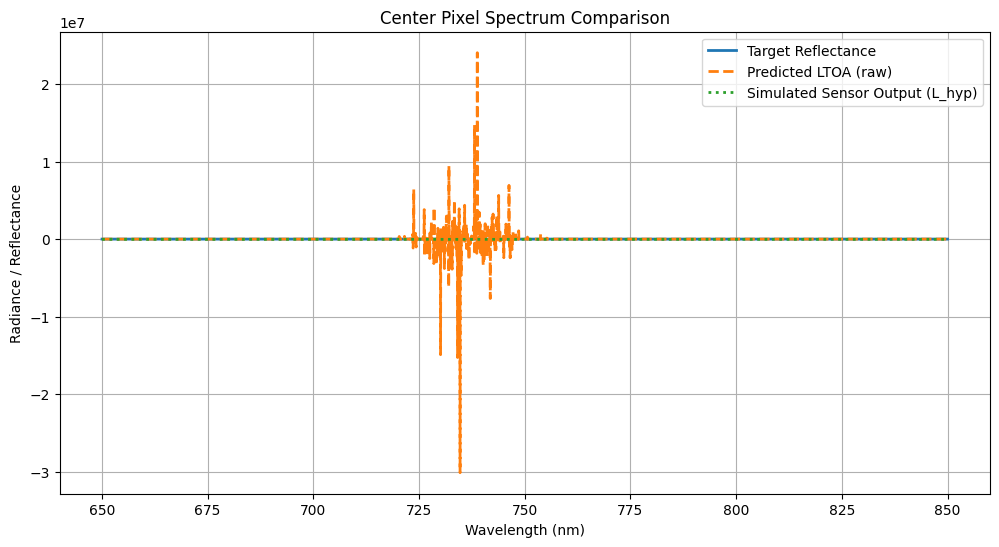

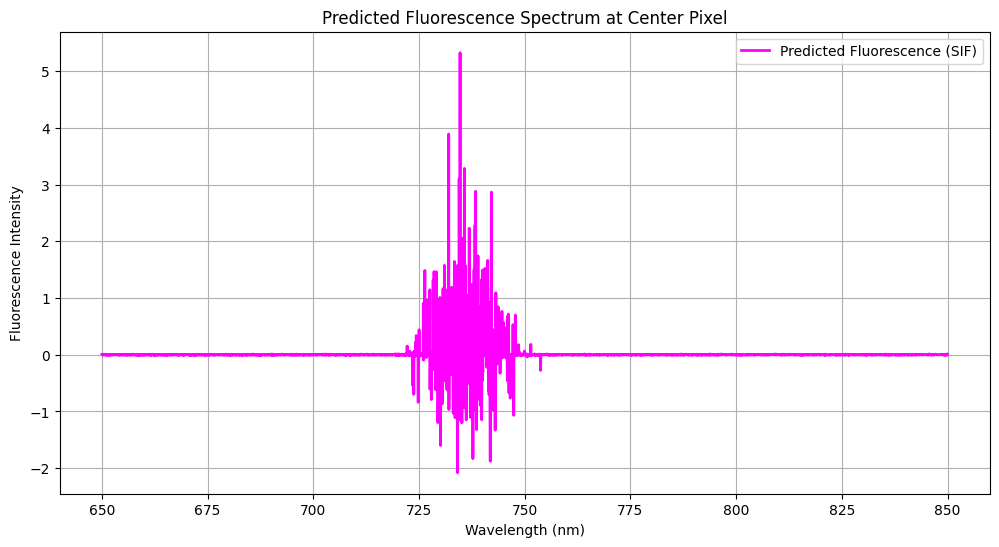

Center Pixel Target Reflectance: [ 6.754405   6.007033   6.6804585 ... 43.3055    36.69765   32.22189  ]
Center Pixel Raw LTOA: [ 0.001277   -0.00151138  0.00184584 ... -0.00111395  0.00163903
 -0.00274399]
Center Pixel Simulated L_hyp: [-32572.887 -32572.887 -32572.887 ... -32572.887 -32572.887 -32572.887]
Center Pixel Predicted SIF Spectrum: [ 0.00687238  0.00066971 -0.0028938  ... -0.00154827 -0.00714957
  0.01031485]


In [19]:
import matplotlib.pyplot as plt
import random

def verify_inference(encoder, simulation, dataset, fixed_esun, sensor_wl, device):
    """
    Randomly selects a patch from the dataset, performs inference,
    and plots:
      - The original target reflectance spectrum (from the patch)
      - The simulated sensor output L_hyp spectrum (after sensor simulation)
      - The raw predicted LTOA spectrum (before sensor simulation)
      - The predicted fluorescence (SIF) spectral signature (without averaging)
    
    Assumes:
      - The dataset returns a tensor of shape [C, H, W] with C = num_wavelengths + 3,
        where the first num_wavelengths channels are LTOA.
      - sensor_wl is a tensor of shape [num_wavelengths].
      - The extra channels are (in order): XTE, SZA, GNDALT.
    """
    encoder.eval()
    simulation.eval()
    
    # Randomly select one patch from the dataset.
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx].unsqueeze(0).to(device)  # shape: [1, C, H, W]
    B, C, H, W = sample.shape
    n_spectral = len(dataset.get_wl())  # e.g., 3620
    
    # Extract target reflectance from the first n_spectral channels.
    target_full = sample[:, :n_spectral, :, :]  # shape: [1, n_spectral, H, W]
    
    # Extract extra channels.
    # Channel order: [0:n_spectral] = LTOA, [n_spectral] = XTE, [n_spectral+1] = SZA, [n_spectral+2] = GNDALT.
    sza = sample[:, n_spectral + 1, :, :]  # shape: [1, H, W]
    # Create E_s from fixed_esun with shape [1, n_spectral, H, W]
    E_s = fixed_esun * torch.ones(1, n_spectral, H, W, device=device)
    cos_theta_s = torch.cos(sza * np.pi / 180.0)  # shape: [1, H, W]
    
    with torch.no_grad():
        latent = encoder(sample)  # expected shape: [1, H, W, 9, latent_dim]
        # Force latent to only have the spectral channels:
        latent = latent[:, :, :, :, :n_spectral]  # Now shape: [1, H, W, 9, n_spectral]
        
        # Extract latent variables; each becomes shape: [1, n_spectral, H, W]
        t1 = latent[:, :, :, 0, :].permute(0, 3, 1, 2)
        t2 = latent[:, :, :, 1, :].permute(0, 3, 1, 2)
        t3 = latent[:, :, :, 2, :].permute(0, 3, 1, 2)
        t4 = latent[:, :, :, 3, :].permute(0, 3, 1, 2)
        t5 = latent[:, :, :, 4, :].permute(0, 3, 1, 2)
        t6 = latent[:, :, :, 5, :].permute(0, 3, 1, 2)
        R_param = latent[:, :, :, 6, :].permute(0, 3, 1, 2)
        F_param = latent[:, :, :, 7, :].permute(0, 3, 1, 2)  # Full spectral fluorescence prediction.
        delta_lambda_enc = latent[:, :, :, 8, :].permute(0, 3, 1, 2)
        delta_lambda = delta_lambda_enc.mean(dim=1)  # [1, H, W]
        
        delta_sigma = torch.tensor(0.0, device=device)
        
        # Compute simulated sensor output L_hyp (after sensor simulation).
        L_hyp = simulation(t1, t2, t3, t4, t5, t6, R_param, F_param,
                           delta_lambda, delta_sigma, E_s, cos_theta_s)
        # L_hyp: [1, n_spectral, H, W]
        
        # Also compute the raw predicted LTOA (before sensor simulation) by calling the four_stream module directly.
        L_toa = simulation.four_stream(t1, t2, t3, t4, t5, t6, R_param, F_param, E_s, cos_theta_s)
        # L_toa: [1, n_spectral, H, W]
        
        # Instead of averaging F_param to a single value, we keep it as full-spectrum.
        predicted_sif = F_param  # [1, n_spectral, H, W]
    
    # For plotting, select the center pixel of the patch.
    center_h, center_w = H // 2, W // 2
    # Get spectra from the center pixel:
    target_spec = target_full[0, :, center_h, center_w].cpu().numpy()  # ground truth reflectance
    L_hyp_spec = L_hyp[0, :, center_h, center_w].cpu().numpy()         # sensor simulated LTOA (L_hyp)
    L_toa_spec = L_toa[0, :, center_h, center_w].cpu().numpy()           # raw LTOA before sensor simulation
    predicted_sif_spec = predicted_sif[0, :, center_h, center_w].cpu().numpy()  # full fluorescence spectrum
    
    # Plot the target reflectance vs. simulated sensor output vs. raw LTOA.
    plt.figure(figsize=(12, 6))
    plt.plot(sensor_wl.cpu().numpy(), target_spec, label='Target Reflectance', linewidth=2)
    plt.plot(sensor_wl.cpu().numpy(), L_toa_spec, label='Predicted LTOA (raw)', linestyle='--', linewidth=2)
    plt.plot(sensor_wl.cpu().numpy(), L_hyp_spec, label='Simulated Sensor Output (L_hyp)', linestyle=':', linewidth=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Radiance / Reflectance')
    plt.title('Center Pixel Spectrum Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the predicted fluorescence spectrum (SIF) at the center pixel.
    plt.figure(figsize=(12, 6))
    plt.plot(sensor_wl.cpu().numpy(), predicted_sif_spec, label='Predicted Fluorescence (SIF)', color='magenta', linewidth=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fluorescence Intensity')
    plt.title('Predicted Fluorescence Spectrum at Center Pixel')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("Center Pixel Target Reflectance:", target_spec)
    print("Center Pixel Raw LTOA:", L_toa_spec)
    print("Center Pixel Simulated L_hyp:", L_hyp_spec)
    print("Center Pixel Predicted SIF Spectrum:", predicted_sif_spec)


# To run verification after training:
# Assume encoder, simulation, dataset, fixed_esun, sensor_wl, device are defined as in train_model().
# For example, after training, call:
sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)
simulation = SFMNNSimulation(sensor_wl).to(device)
fixed_esun = dataset.fixed_esun
verify_inference(encoder, simulation, dataset, fixed_esun, sensor_wl, device)

----
# <center>Playground, this is for testing purposes

In [18]:
#!/usr/bin/env python3
import os
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import logging

################################################################################
# Logging
################################################################################
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    handlers=[logging.StreamHandler()])
logger = logging.getLogger("train_sfmnn")

################################################################################
# Dataset
################################################################################
class SFMNNDataset(Dataset):
    """
    This Dataset is designed to mimic your simulation JSON files.
    It expects a lookup table JSON (with key "modtran_wavelength") and a folder
    containing simulation JSON files. Each JSON is assumed to have:
      - "LTOA": a list (or array) of length n_spectral (e.g., 3620)
      - "MODTRAN_settings": with subkeys under "ATM" for SZA, VZA, GNDALT.
      - Optionally "Esun".
    Here, for demonstration, we create random patches if no files are found.
    
    Each patch is returned as a tensor of shape [C, H, W], where
      C = n_spectral + 3  (last three channels are: XTE, SZA, GNDALT)
    """
    def __init__(self, lookup_table_path, data_folder, patch_size=5, n_spectral=3620):
        super().__init__()
        self.patch_size = patch_size
        self.n_spectral = n_spectral

        # Load wavelengths from lookup table
        with open(lookup_table_path, "r") as f:
            lookup = json.load(f)
        self.wl = np.array(lookup["modtran_wavelength"])  # shape (n_spectral,)

        # List all simulation JSON files in data_folder.
        sim_files = sorted(glob.glob(os.path.join(data_folder, "simulation_sim_*.json")))
        if len(sim_files) == 0:
            logger.warning("No simulation JSON files found; using dummy data.")

        self.patches = []
        LTOA_list = []
        XTE_list = []
        SZA_list = []
        GNDALT_list = []
        Esun_list = []
        
        for file_path in sim_files:
            with open(file_path, "r") as f:
                data = json.load(f)
            LTOA_value = np.array(data["LTOA"], dtype=np.float32)  # shape (n_spectral,)
            SZA_value = float(data["MODTRAN_settings"]["ATM"]["SZA"])
            VZA_value = float(data["MODTRAN_settings"]["ATM"]["VZA"])
            GNDALT_value = float(data["MODTRAN_settings"]["ATM"]["GNDALT"])
            # Compute XTE = tan(VZA) * GNDALT
            xte_val = np.tan(np.deg2rad(VZA_value)) * GNDALT_value
            esun_val = float(data.get("Esun", 1.0))
            
            LTOA_list.append(LTOA_value)
            SZA_list.append(SZA_value)
            XTE_list.append(xte_val)
            GNDALT_list.append(GNDALT_value)
            Esun_list.append(esun_val)
        
        if len(LTOA_list) == 0:
            num_samples = 50
            for i in range(num_samples):
                LTOA_list.append(np.random.rand(self.n_spectral).astype(np.float32))
                SZA_list.append(30.0 + np.random.rand()*10)  # between 30 and 40 deg
                XTE_list.append(np.random.rand()*100)
                GNDALT_list.append(np.random.rand()*50)
                Esun_list.append(1500.0)
        
        self.fixed_esun = float(np.mean(Esun_list))
        logger.info(f"Computed fixed Esun: {self.fixed_esun:.4f}")

        for i in range(len(LTOA_list)):
            patch = np.zeros((self.n_spectral + 3, self.patch_size, self.patch_size), dtype=np.float32)
            for band in range(self.n_spectral):
                patch[band, :, :] = LTOA_list[i][band]
            patch[self.n_spectral + 0, :, :] = XTE_list[i]
            patch[self.n_spectral + 1, :, :] = SZA_list[i]
            patch[self.n_spectral + 2, :, :] = GNDALT_list[i]
            self.patches.append(torch.from_numpy(patch))
    
    def get_wl(self):
        return self.wl

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


################################################################################
# Four-Stream Simulator (High-Res Domain)
################################################################################
class FourStreamSimulator(nn.Module):
    def __init__(self):
        super().__init__()
        # Implements the physical forward model.
    
    def forward(self, t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s):
        # All inputs: [B, 3620, H, W]
        denom = 1.0 - t3 * R
        denom = denom.clamp(min=1e-4)
    
        LTOA_part1 = t1 * t2
        LTOA_part2 = (t1 * t4 * R + t2 * R + t5 * R + t6 * F) / denom
        LTOA_noIrrad = LTOA_part1 + LTOA_part2
    
        mod_factor = (E_s * cos_theta_s) / np.pi
        LTOA = LTOA_noIrrad * mod_factor  # [B, 3620, H, W]
        return LTOA


################################################################################
# HyPlant Sensor Simulator (Downsampling to Sensor Domain)
################################################################################
class HyPlantSensorSimulator(nn.Module):
    def __init__(self, sensor_wavelengths, high_res_range, high_res_steps):
        """
        sensor_wavelengths: Tensor [sensor_channels] (e.g., 172 points over [750,770])
        high_res_range: tuple, e.g., (750,770)
        high_res_steps: number of high-res channels (e.g., 3620)
        """
        super().__init__()
        self.sensor_wavelengths = sensor_wavelengths  # [sensor_channels]
        self.sensor_channels = sensor_wavelengths.shape[0]
        self.high_res_range = high_res_range
        self.high_res_steps = high_res_steps
        self.register_buffer('wl_hr', torch.linspace(high_res_range[0], high_res_range[1], steps=high_res_steps))
    
    def forward(self, L_hr, delta_lambda, delta_sigma):
        """
        L_hr: [B, high_res_steps, H, W] (e.g., [B,3620,H,W])
        delta_lambda: [B, H, W]
        delta_sigma: scalar
        This module:
         1. Applies a Gaussian blur along the spectral dimension.
         2. Shifts the sensor wavelengths by avg(delta_lambda).
         3. Uses grid_sample to re-sample L_hr to sensor space.
        Returns:
          L_sensor: [B, sensor_channels, H, W]
        """
        B, C_hr, H, W = L_hr.shape
        device = L_hr.device
        
        # Gaussian blur:
        sigma = (0.27 + delta_sigma) * 2.3548  # FWHM->std
        sigma = sigma if not torch.is_tensor(sigma) else sigma.item()
        kernel_size = max(3, int(6 * sigma / ((self.high_res_range[1]-self.high_res_range[0])/self.high_res_steps)))
        if kernel_size % 2 == 0:
            kernel_size += 1
        x = torch.linspace(-3*sigma, 3*sigma, kernel_size, device=device)
        kernel = torch.exp(-0.5 * (x/sigma)**2)
        kernel /= kernel.sum()
        kernel = kernel.view(1,1,-1)
    
        L_hr_reshaped = L_hr.permute(0,2,3,1).reshape(B*H*W, 1, C_hr)
        L_blur = F.conv1d(L_hr_reshaped, kernel, padding=kernel_size//2)
        new_C_hr = L_blur.shape[-1]
        L_blur = L_blur.view(B, H, W, new_C_hr).permute(0,3,1,2)
    
        # Wavelength shift:
        avg_delta = delta_lambda.mean(dim=(1,2))  # [B]
        shifted_sensor_wl = self.sensor_wavelengths.unsqueeze(0) + avg_delta.unsqueeze(1)  # [B, sensor_channels]
        wl_min, wl_max = self.high_res_range
        normalized_sensor_wl = 2 * (shifted_sensor_wl - wl_min) / (wl_max - wl_min) - 1  # [B, sensor_channels]
    
        # Grid sampling:
        L_blur_2d = L_blur.permute(0,2,3,1).reshape(B*H*W, 1, new_C_hr, 1)
        grid_y = normalized_sensor_wl.unsqueeze(1).expand(B, H*W, self.sensor_channels)
        grid_x = torch.zeros_like(grid_y)
        grid = torch.stack((grid_y, grid_x), dim=-1)
        grid = grid.reshape(B*H*W, 1, self.sensor_channels, 2)
    
        L_sampled = F.grid_sample(L_blur_2d, grid, mode='bilinear', padding_mode='border', align_corners=True)
        L_sampled = L_sampled.view(B, H, W, self.sensor_channels).permute(0,3,1,2)
    
        return L_sampled


################################################################################
# Full SFMNN Simulation (Combine Four-Stream and Sensor Simulation)
################################################################################
class SFMNNSimulation(nn.Module):
    def __init__(self, sensor_wavelengths, high_res_range=(750,770), high_res_steps=3620):
        super().__init__()
        self.four_stream = FourStreamSimulator()
        self.sensor_sim = HyPlantSensorSimulator(sensor_wavelengths, high_res_range, high_res_steps)
    
    def forward(self, t1, t2, t3, t4, t5, t6, R, F,
                delta_lambda, delta_sigma,
                E_s, cos_theta_s):
        L_hr = self.four_stream(t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s)
        L_sensor = self.sensor_sim(L_hr, delta_lambda, delta_sigma)
        return L_sensor


################################################################################
# SFMNN Loss
################################################################################
class SFMNNLoss(nn.Module):
    def __init__(self, gamma_f=5, gamma_N=10, gamma_a=1,
                 ndvi_threshold=0.15, red_idx=30, nir_idx=60):
        """
        red_idx and nir_idx are indices into the sensor domain (0..sensor_channels-1)
        """
        super().__init__()
        self.gamma_f = gamma_f
        self.gamma_N = gamma_N
        self.gamma_a = gamma_a
        self.ndvi_threshold = ndvi_threshold
        self.red_idx = red_idx
        self.nir_idx = nir_idx
    
    def forward(self, pred, target, outputs, E_s, cos_theta_s, loss_indices):
        # pred, target: [B, sensor_channels, H, W]
        eps = 1e-6
        recon_loss = torch.mean((pred - target)**2)
    
        # NDVI loss using simulated reflectance in sensor space.
        reflectance = outputs['reflectance']  # expected shape: [B, sensor_channels, H, W]
        B, C, H, W = reflectance.shape
        if self.red_idx >= C or self.nir_idx >= C:
            logger.warning("red_idx or nir_idx out of range; adjusting.")
            red_idx = min(self.red_idx, C-2)
            nir_idx = min(self.nir_idx, C-1)
        else:
            red_idx, nir_idx = self.red_idx, self.nir_idx
        red = reflectance[:, red_idx, :, :].clamp_min(eps)
        nir = reflectance[:, nir_idx, :, :].clamp_min(eps)
        ndvi = (nir - red) / (nir + red + eps)
        sif_pred = outputs['sif']  # [B, H, W]
        ndvi_loss = torch.mean(sif_pred * (ndvi <= self.ndvi_threshold).float())
    
        signal_loss = torch.mean((pred - target)**2)
        atm_loss = torch.tensor(0.0, device=pred.device)
    
        total_loss = recon_loss + self.gamma_f * signal_loss + self.gamma_N * ndvi_loss + self.gamma_a * atm_loss
        loss_dict = {
            'total': total_loss,
            'recon': recon_loss,
            'signal': signal_loss,
            'ndvi': ndvi_loss,
            'atm': atm_loss
        }
        return total_loss, loss_dict


################################################################################
# SFMNN Encoder
################################################################################
class SFMNNEncoder(nn.Module):
    """
    An MLP-based encoder that takes input [B, C, H, W] with C = n_spectral+3
    and outputs latent representations per pixel of shape:
       [B, H, W, 9, latent_dim]  where latent_dim = n_spectral (e.g., 3620)
    """
    def __init__(self, input_channels=3623, num_variables=9, latent_dim=3620):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_variables = num_variables
        self.input_norm = nn.BatchNorm1d(input_channels)
        self.fc_layers = nn.Sequential(
            nn.Linear(input_channels, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4096, 8192),
            nn.BatchNorm1d(8192),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8192, 16384),
            nn.BatchNorm1d(16384),
            nn.ReLU(),
            nn.Linear(16384, num_variables * latent_dim)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.view(B*H*W, C)
        x_norm = self.input_norm(x_flat)
        x_fc = self.fc_layers(x_norm)
        latent = x_fc.view(B, H, W, self.num_variables, self.latent_dim)
        return latent


################################################################################
# Training Loop
################################################################################
def train_sfmnn(data_folder, lookup_table_path, patch_size=5,
                num_epochs=20, lr=1e-4, batch_size=4,
                n_spectral=3620, sensor_channels=172):
    dataset = SFMNNDataset(lookup_table_path, data_folder, patch_size=patch_size, n_spectral=n_spectral)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    total_input_channels = n_spectral + 3
    logger.info(f"Input channels: {total_input_channels}")
    
    encoder = SFMNNEncoder(input_channels=total_input_channels, num_variables=9, latent_dim=n_spectral).to(device)
    
    sensor_wavelengths = torch.linspace(750, 770, steps=sensor_channels).to(device)
    simulation = SFMNNSimulation(sensor_wavelengths, high_res_range=(750,770), high_res_steps=n_spectral).to(device)
    
    loss_fn = SFMNNLoss(gamma_f=5, gamma_N=10, gamma_a=1, ndvi_threshold=0.15,
                        red_idx=30, nir_idx=60).to(device)
    
    optimizer = optim.Adam(encoder.parameters(), lr=lr, weight_decay=1e-5)
    
    # To simulate a sensor measurement target, we perform naive binning from the high-res LTOA.
    # Since n_spectral might not be exactly divisible by sensor_channels, we slice off the extra channels.
    factor = n_spectral // sensor_channels  # integer division
    used_channels = sensor_channels * factor  # total channels to use
    
    for epoch in range(num_epochs):
        encoder.train()
        epoch_loss = 0.0
        num_samples = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
        for batch in pbar:
            batch = batch.to(device)  # shape: [B, total_input_channels, H, W]
            B, C, H, W = batch.shape
            
            # Raw LTOA from first n_spectral channels
            target_full = batch[:, :n_spectral, :, :]  # [B, n_spectral, H, W]
            # Use only the first used_channels channels for binning
            target_binned = target_full[:, :used_channels, :, :]
            target = target_binned.reshape(B, sensor_channels, factor, H, W).mean(dim=2)  # [B, sensor_channels, H, W]
    
            # Build E_s and cos_theta_s in high-res domain.
            E_s = dataset.fixed_esun * torch.ones(B, n_spectral, H, W, device=device)
            sza = batch[:, n_spectral+1, :, :]  # SZA channel, shape: [B, H, W]
            cos_theta_s = torch.cos(sza * np.pi/180.0).unsqueeze(1).expand(-1, n_spectral, -1, -1)  # [B, n_spectral, H, W]
    
            latent = encoder(batch)  # shape: [B, H, W, 9, n_spectral]
            t1 = latent[:, :, :, 0, :].permute(0,3,1,2)  # [B, n_spectral, H, W]
            t2 = latent[:, :, :, 1, :].permute(0,3,1,2)
            t3 = latent[:, :, :, 2, :].permute(0,3,1,2)
            t4 = latent[:, :, :, 3, :].permute(0,3,1,2)
            t5 = latent[:, :, :, 4, :].permute(0,3,1,2)
            t6 = latent[:, :, :, 5, :].permute(0,3,1,2)
            R_param = latent[:, :, :, 6, :].permute(0,3,1,2)
            F_param = latent[:, :, :, 7, :].permute(0,3,1,2)
            delta_lambda_enc = latent[:, :, :, 8, :].permute(0,3,1,2)
            delta_lambda = delta_lambda_enc.mean(dim=1)  # [B, H, W]
            delta_sigma = torch.tensor(0.0, device=device)
    
            R_param = R_param.clamp(0.0, 0.98)
            predicted_sif = F_param.mean(dim=1)  # [B, H, W]
            outputs_dict = {'reflectance': R_param, 'sif': predicted_sif}
    
            pred = simulation(t1, t2, t3, t4, t5, t6, R_param, F_param,
                              delta_lambda, delta_sigma, E_s, cos_theta_s)
            # pred: [B, sensor_channels, H, W]
    
            loss, loss_dict = loss_fn(pred, target, outputs_dict, E_s, cos_theta_s, None)
    
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5.0)
            optimizer.step()
    
            epoch_loss += loss.item() * B
            num_samples += B
            pbar.set_postfix({
                "loss": loss.item(),
                "recon": loss_dict['recon'].item(),
                "signal": loss_dict['signal'].item(),
                "ndvi": loss_dict['ndvi'].item(),
                "atm": loss_dict['atm'].item()
            })
    
        avg_epoch_loss = epoch_loss / num_samples
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}")
    
    logger.info("Training complete!")


################################################################################
# Main
################################################################################
if __name__ == "__main__":
    # Set these paths to your real data.
    data_folder = "./output/"  # folder containing simulation_sim_*.json files
    lookup_table = "./output/simulation_lookuptable.json"
    train_sfmnn(data_folder, lookup_table, patch_size=5, num_epochs=20, lr=1e-4, batch_size=4)


TypeError: float() argument must be a string or a real number, not 'list'